In [15]:
import os
import urllib
from IPython.display import Video
import imageio.v3 as iio
import pickle
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.transform import Rotation
from PIL import Image, ImageDraw, ImageFont

In [16]:
# check the video
video_name = "10515012-hd_3840_2160_24fps.mp4"
video_stem = os.path.splitext(video_name)[0]
video_path = f"../data/{video_name}"
Video(video_path, width=600)

In [17]:
# lets download the model
model_name = "face_landmarker.task"
model_url = "https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/latest/face_landmarker.task"

os.makedirs("../models", exist_ok=True)
model_path = f"../models/{model_name}"
if not os.path.exists(model_path):
    urllib.request.urlretrieve(model_url, model_path)
    
print(f"Model {model_name} is downloaded.")

Model face_landmarker.task is downloaded.


In [18]:
# debug function to draw the landmarks
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

# also draw axis
def draw_axis_on_image(rgb_image, detection_result):
  matrix = detection_result.facial_transformation_matrixes[0]
  annotated_image = np.copy(rgb_image)
  
  R = -matrix[:3, :3]
  T = -matrix[:3, 3]
  solutions.drawing_utils.draw_axis(
      annotated_image,
      R,
      T,
      axis_length=10,
  )
  return annotated_image
  

In [19]:
# prepare mediapipe settings
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode
options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO,
    output_facial_transformation_matrixes=True
)

# init mediapipe
landmarker = FaceLandmarker.create_from_options(options)

# prepare video input
input = iio.imiter(video_path, plugin="pyav")
meta = iio.immeta(video_path, plugin="pyav")
fps = meta["fps"]

# prepare video output
os.makedirs("../out", exist_ok=True)
out_video_path = f"../out/{video_stem}_raw_tracking.mp4"
out_tracking_path = f"../out/{video_stem}_tracking.pkl"

# process video
data = []
with iio.imopen(out_video_path, "w", plugin="pyav") as output:
    output.init_video_stream("h264", fps=fps)
    
    for i, frame in enumerate(input):
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        ts = int((i / fps) * 1000)  # timestamp in milliseconds

        # Run pose detection
        detection = landmarker.detect_for_video(mp_image, timestamp_ms=ts)
        annotated = draw_landmarks_on_image(frame, detection)
        annotated = draw_axis_on_image(annotated, detection)
        data.append(detection)

        # save annotated frame to output
        output.write_frame(annotated)

landmarker.close()

# save tracking
with open(out_tracking_path, "wb") as f:
    pickle.dump(data, f)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

I0000 00:00:1749425309.197394   79612 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1749425309.198031   79612 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)


In [20]:
# lets see the results
Video(out_video_path, width=1200)

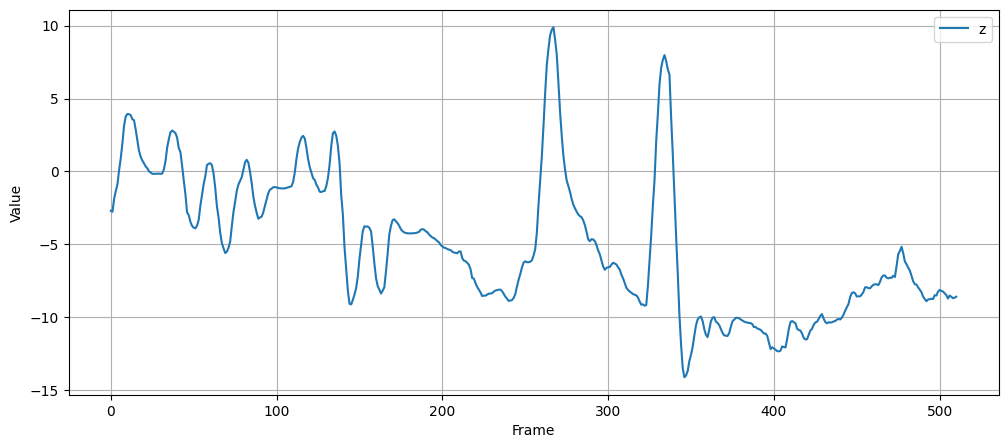

In [21]:
# lets do a time series of eueler angles for each frame
euler_angles = []
for detection in data:
    R = detection.facial_transformation_matrixes[0][:3, :3]
    rotation = Rotation.from_matrix(R)
    euler = rotation.as_euler('zyx', degrees=True)
    euler_angles.append(euler)

# negative to make it clockwise    
euler_angles = -np.array(euler_angles)

plt.figure(figsize=(12, 5))
plt.plot(euler_angles[:, 2], label='z')
plt.xlabel("Frame")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# lets visualize that along with the video
font = ImageFont.truetype("DejaVuSans.ttf", size=64)

angle_name = f"{video_stem}_angle"
angle_path = f"../out/{angle_name}.mp4"
output = iio.imopen(angle_path, "w", plugin="pyav")
output.init_video_stream("h264", fps=fps)

input = iio.imiter(out_video_path, plugin="pyav")
for i, frame in enumerate(input):
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)

    # Draw the counter in red
    draw.text((30, 30), f"Z: {euler_angles[i, 2]}", fill=(255, 0, 0), font=font)       
    output.write_frame(np.array(img)) 
    
output.close()     

In [23]:
# lets see the results
Video(angle_path, width=1000)

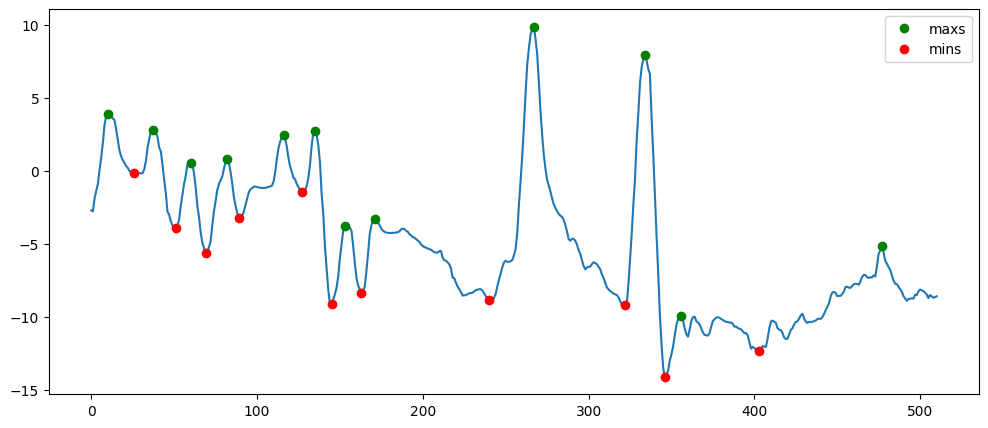

In [24]:
# yeah seems to work
# lets treat the Z-angle as a signal
# we can find local extremas when the head is down and up

from scipy.signal import find_peaks

prominence=2

z_signal = euler_angles[:, 2]
mins, _ = find_peaks(-z_signal, prominence=prominence)
maxs, _ = find_peaks(z_signal, prominence=prominence)

plt.figure(figsize=(12, 5))
plt.plot(z_signal)
plt.plot(maxs, z_signal[maxs], "go", label="maxs")
plt.plot(mins, z_signal[mins], "ro", label="mins")
plt.legend()
plt.show()

In [25]:
# we can count nodding as a pattern up-down
# so let just count how many times this pattern repeats during video
# we would assume that the first point is local max and last is local min

max_queue = list(maxs)
min_queue = list(mins)
if max_queue[0] > min_queue[0]:
    max_queue.insert(0, 0)
if min_queue[-1] < max_queue[-1]:
    min_queue.append(len(z_signal) - 1)

nodding_interv = []
while len(max_queue) > 0 and len(min_queue) > 0:
    start_pos = max_queue.pop(0)
    down_pos = min_queue.pop(0)
    nodding_interv.append((start_pos, down_pos))

print(len(nodding_interv))
print(nodding_interv)

12
[(10, 26), (37, 51), (60, 69), (82, 89), (116, 127), (135, 145), (153, 163), (171, 240), (267, 322), (334, 346), (356, 403), (477, 510)]


In [26]:
detection_name = f"{video_stem}_detection"
detection_path = f"../out/{detection_name}.mp4"
output = iio.imopen(detection_path, "w", plugin="pyav")
output.init_video_stream("h264", fps=fps)

nodding_counter = 0
video_nodes_interv = nodding_interv.copy()
current_nodding = video_nodes_interv.pop(0)

input = iio.imiter(angle_path, plugin="pyav")
for i, frame in enumerate(input):
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)

    start, end = current_nodding
    
    # todo: maybe some extra visuals here
    if i < start:
        pass
    elif i == start:
        pass
    elif start < i < end:
        pass
    elif i >= end - 1:
        nodding_counter += 1
        if len(video_nodes_interv) > 0:
            current_nodding = video_nodes_interv.pop(0)

    # Draw the counter
    draw.text((30, 120), f"Nods: {nodding_counter}", fill=(0, 255, 0), font=font)       
    output.write_frame(np.array(img)) 
    
output.close()     

In [27]:
# lets see the results
Video(detection_path, width=1000)